In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
MODEL_NAME = "google-bert/bert-base-multilingual-cased"

In [2]:
config_df = pd.read_csv("mbert_indo.csv")
epoch_df = pd.read_csv("mbert_indo_epoch.csv")
epoch_df.head()
config_df.head()

,config_id,type_test,model_name,pooling_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,classifier_dropout,weight_decay,training_time,peak_memory,test_mse,test_mae,test_rmse,test_pearson
0,0,before balancing,google-bert/bert-base-multilingual-cased,cls,16,13,0.00002,0,0,0.1,0.01,1308.885942,6996.725098,0.013665,0.093302,0.116898,0.916253
1,1,after balancing,google-bert/bert-base-multilingual-cased,cls,16,14,0.00002,0,0,0.1,0.01,3074.263074,6996.725098,0.015156,0.098380,0.123110,0.911575


# Training Plot

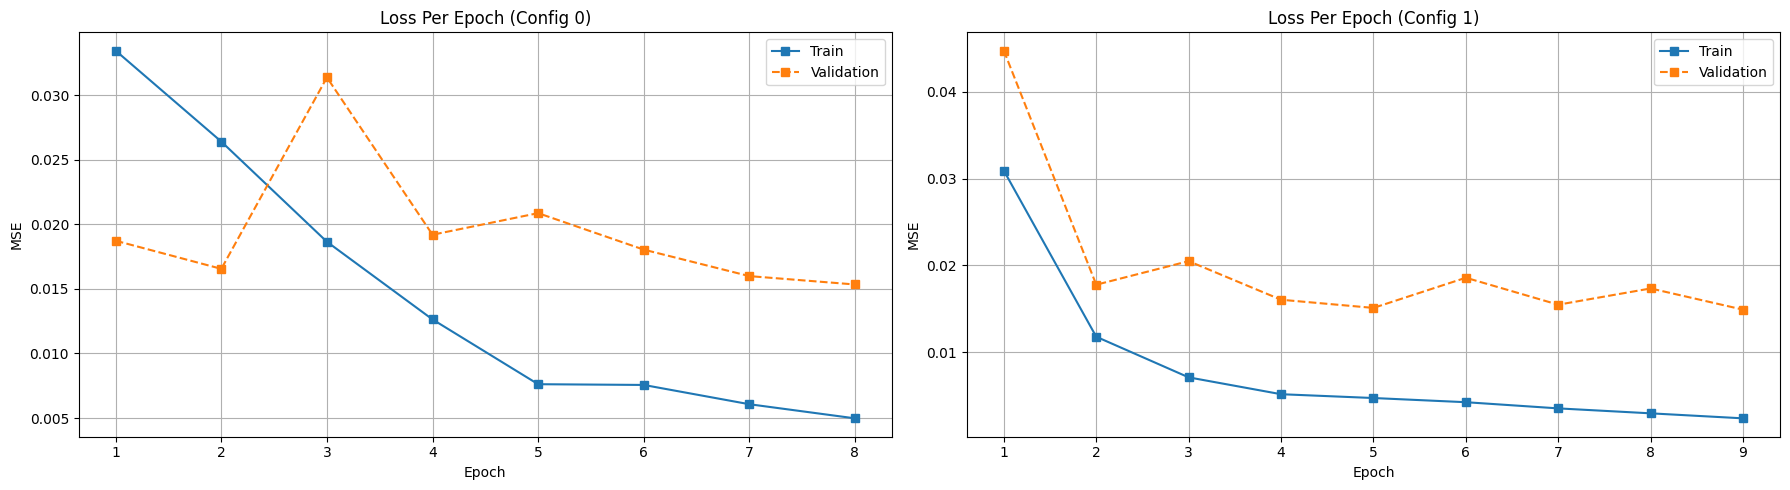

In [3]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


In [4]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import AutoTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = RegressionModel(MODEL_NAME, pooling_type='cls').to('cuda')
def predict(df_test, config_id):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/balancing/cross/mbert_indo_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                preds = torch.clamp(predictions, 0, 1)

                all_predictions.extend(preds.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [5]:
import pandas as pd

df_config = pd.read_csv("mbert_indo.csv")

df_test = pd.read_csv("../../../../data/clean/cross/test_indo.csv")
for row in df_config.itertuples():
    all_predictions, all_targets = predict(df_test, row.config_id)

    # buat kolom prediksi skor
    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "mbert_predictions_indo.csv"))

c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



>> Tanpa Augmentasi - predicted_score_0
RMSE: 0.1087, Pearson: 0.9160

>> Dengan Augmentasi - predicted_score_1
RMSE: 0.1231, Pearson: 0.9116


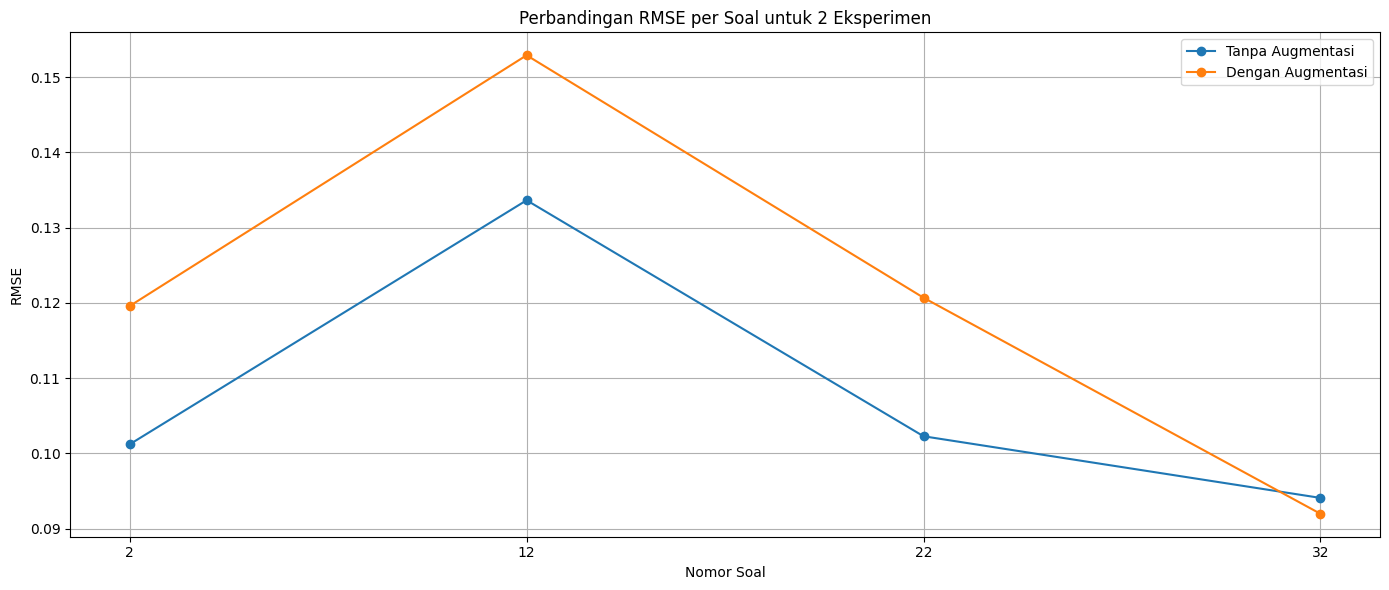

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv") and f.startswith("mbert")]

# ambil warna
color_palette = plt.get_cmap("tab10")

# label eksperimen
label_map = {
    "predicted_score_0": "Tanpa Augmentasi",
    "predicted_score_1": "Dengan Augmentasi"
}

# menyimpan rmse dan metrik
rmse_per_model = {}
metric_eval_data = {}
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        # hitung metrik
        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        # get label
        label = label_map.get(col, col)
        print(f"\n>> {label} - {col}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        # rmse per soal
        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

# ekstrak nomor soal
def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

# trend plot
plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    # ekstrak nomor soal
    soal_numbers = extract_soal_number(rmse_series.index)
    
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 2 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique()))
plt.tight_layout()
plt.show()

In [7]:
fixed_threshold = 0.1

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))

for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    outlier_fixed2 = np.abs(residuals) > 0.2
    outlier_fixed = np.abs(residuals) > fixed_threshold

    num_outliers_fixed2 = np.sum(outlier_fixed2)
    num_outliers_fixed = np.sum(outlier_fixed)

    print(f"{label}:")
    print(f"  Outlier (Fixed ±0.2): {num_outliers_fixed2}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")


Tanpa Augmentasi:
  Outlier (Fixed ±0.2): 10
  Outlier (Fixed ±0.1): 76

Dengan Augmentasi:
  Outlier (Fixed ±0.2): 15
  Outlier (Fixed ±0.1): 90

